In [2]:
import numpy as np
from pyfwat.pario import readpar
from pyproj import Proj
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def get_vp_rho(vs):
    vp = 0.9409 + 2.0947*vs - 0.8206*vs**2 + 0.2683*vs**3 - 0.0251*vs**4
    rho = 1.6612*vp - 0.4721*vp**2 + 0.0671*vp**3 - 0.0043*vp**4 + 0.000106*vp**5
    # vs = 0.7858 - 1.2344*vp + 0.7949*vp**2 - 0.1238*vp**3 + 0.0064*vp**4
    return vp, rho

In [4]:
# define axis
lat_min = readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'LATITUDE_MIN')
lat_max = readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'LATITUDE_MAX')
lon_min = readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'LONGITUDE_MIN')
lon_max = readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'LONGITUDE_MAX')
dep_max = readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'DEPTH_BLOCK_KM')
print ('lat_min, lat_max, lon_min, lon_max, dep_max:', lat_min, lat_max, lon_min, lon_max, dep_max)
zmax = 0
zmin = -dep_max*1000
zone = int(readpar('./DATA/meshfem3D_files/Mesh_Par_file', 'UTM_PROJECTION_ZONE'))
geo2utm = Proj(proj='utm', zone=zone, ellps='WGS84')
xmin1, ymin1 = geo2utm(lon_min, lat_min)
xmin2, ymin2 = geo2utm(lon_min, lat_max)
xmin = min(xmin1, xmin2)
xmax1, ymax1 = geo2utm(lon_max, lat_min)
xmax2, ymax2 = geo2utm(lon_max, lat_max)
xmax = max(xmax1, xmax2)
xmin1, ymin1 = geo2utm(lon_min, lat_min)
xmin2, ymin2 = geo2utm(lon_max, lat_min)
ymin = min(ymin1, ymin2)
xmax1, ymax1 = geo2utm(lon_min, lat_max)
xmax2, ymax2 = geo2utm(lon_max, lat_max)
ymax = max(ymax1, ymax2)
print('xmin, xmax, ymin, ymax:', xmin, xmax, ymin, ymax)
dh = 2000
x = np.arange(xmin, xmax+dh, dh)
y = np.arange(ymin, ymax+dh, dh)
dz = 1000
z = np.arange(zmin, zmax+dz, dz)

lat_min, lat_max, lon_min, lon_max, dep_max: -1.0 1.0 -1.0 1.0 32.0
xmin, xmax, ymin, ymax: 722561.736478863 945396.6839773951 -110801.83254625657 110801.83254625657


In [5]:
# build initial model
vsmin, vsmax = 3.3, 4.0
vs = np.zeros((len(x), len(y), len(z)))
idx = np.where(z >= -27000)[0]
vs[:, :, idx] = np.linspace(vsmin, vsmax, len(idx))[::-1][np.newaxis, np.newaxis, :]
vs[:, :, z < -27000] = vsmax
vp, rho = get_vp_rho(vs)
with h5py.File('initial_model.h5', 'w') as f:
    f.create_dataset('x', data=x)
    f.create_dataset('y', data=y)
    f.create_dataset('z', data=z)
    f.create_dataset('vp', data=vp*1000)
    f.create_dataset('vs', data=vs*1000)
    f.create_dataset('rho', data=rho*1000)

In [6]:
def create_taper(xleft, xright, axis):
    delta = axis[1] - axis[0]
    ntaper_left = int((xleft-axis[0])/delta)
    ntaper_right = int((axis[-1]-xright)/delta)
    return ntaper_left, ntaper_right

In [7]:
# create checkerboard model
limh = 40000
limz = [-30000, 0]
n_pert_x = 2
n_pert_y = 2
n_pert_z = 2
pertv = 0.12

x_pert = np.zeros_like(x)
ntaper_left, ntaper_right = create_taper(x[0]+limh, x[-1]-limh, x)
x_pert[ntaper_left:x.size-ntaper_right] = \
            np.sin(n_pert_x*np.pi*np.arange(x.size-(ntaper_left+ntaper_right))/ \
            (x.size-(ntaper_left+ntaper_right)))
print('size of anomaly:', (x[-1]-x[0]-2*limh)/n_pert_x)


y_pert = np.zeros_like(y)
ntaper_left, ntaper_right = create_taper(y[0]+limh, y[-1]-limh, y)
y_pert[ntaper_left:y.size-ntaper_right] = \
            np.sin(n_pert_y*np.pi*np.arange(y.size-(ntaper_left+ntaper_right))/ \
            (y.size-(ntaper_left+ntaper_right)))
print('size of anomaly:', (y[-1]-y[0]-2*limh)/n_pert_y)

z_pert = np.zeros_like(z)
ntaper_left, ntaper_right = create_taper(limz[0], limz[1], z)
# ntaper_right = 0

z_pert[ntaper_left:z.size-ntaper_right] = \
            np.sin(n_pert_z*np.pi*np.arange(z.size-(ntaper_left+ntaper_right))/ \
            (z.size-(ntaper_left+ntaper_right)))
print('size of anomaly:', (limz[1]-limz[0])/n_pert_z)

xx, yy, zz = np.meshgrid(x_pert, y_pert, z_pert, indexing='ij')
pert = xx*yy*zz*pertv
vs_pert = vs*(1+pert)
vp_pert, rho_pert = get_vp_rho(vs_pert)
with h5py.File('target_model.h5', 'w') as f:
    f.create_dataset('x', data=x)
    f.create_dataset('y', data=y)
    f.create_dataset('z', data=z)
    f.create_dataset('vp', data=vp_pert*1000)
    f.create_dataset('vs', data=vs_pert*1000)
    f.create_dataset('rho', data=rho_pert*1000)

size of anomaly: 72000.0
size of anomaly: 71000.0
size of anomaly: 15000.0


In [8]:
# create station template
dsta = 40000
lim = 20000
sta = []
nsta = 1
utm2geo = Proj(proj='latlong', zone=zone, datum='WGS84')
for j, sty in enumerate(np.linspace(ymin+lim, ymax-lim, 7)):
    for i, stx in enumerate(np.linspace(xmin+lim, xmax-lim, 7)):
        stnm = 'ST{:03d}'.format(nsta)
        stlo, stla = geo2utm(stx, sty, inverse=True)
        sta.append([stnm, 'MX', stla, stlo, 0.0, 0.0])
        nsta += 1

sta = pd.DataFrame(sta, columns=['stnm', 'net', 'lat', 'lon', 'elev', 'depth'])
sta.to_csv('./DATA/STATIONS', sep=' ', index=False, header=False)

-20000.0


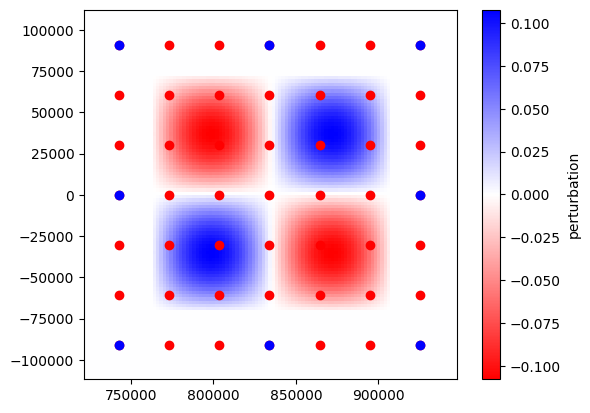

In [ ]:
plt.figure()
plt.pcolor(x, y, pert[:, :, 12].T, cmap='bwr_r')
plt.colorbar(label='perturbation')
plt.gca().set_aspect('equal')
print(z[12])
stxx, styy = geo2utm(sta.lon, sta.lat)
plt.plot(stxx, styy, 'ro')
plt.plot(stxx[0], styy[0], 'bo')
plt.plot(stxx[6], styy[6], 'bo')
plt.plot(stxx[42], styy[42], 'bo')
plt.plot(stxx[48], styy[48], 'bo')
plt.plot(stxx[3], styy[3], 'bo')
plt.plot(stxx[27], styy[27], 'bo')
plt.plot(stxx[45], styy[45], 'bo')
plt.plot(stxx[21], styy[21], 'bo')